# How to Run
1) Download our trained model from here:  https://drive.google.com/file/d/1Hz63ZAzbvQKdc2-5RnQ1AvbulwsLCYb-/view?usp=sharing

2) To run in Collab, drag the model you downloaded to the local root directory in Collab under Files tab on the left. (So it will be accessed later like this: "./JohnnyOModel").

3) Run all the cells

In [1]:
import requests
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
from torch.nn import functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.functional import pad
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Clone our repo to get the testing data
!git clone https://github.com/arjungandhi521/deepfake-generation.git

Cloning into 'deepfake-generation'...
remote: Enumerating objects: 10952, done.
remote: Counting objects: 100% (5270/5270), done.
remote: Compressing objects: 100% (5255/5255), done.
remote: Total 10952 (delta 28), reused 5250 (delta 14), pack-reused 5682
Receiving objects: 100% (10952/10952), 249.60 MiB | 37.78 MiB/s, done.
Resolving deltas: 100% (59/59), done.


# Class Defenitions from "Auto Encoder" needed for demo

In [3]:
# We are using this code block from this repository
# https://github.com/hanqingguo/deepfake-pytorch/blob/master/padding_same_conv.py
class _ConvNd(Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding, groups, bias):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def __repr__(self):
        s = ('{name}({in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)


class Conv2d(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)

    def forward(self, input):
        return conv2d_same_padding(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


# custom con2d, because pytorch don't have "padding='same'" option.
def conv2d_same_padding(input, weight, bias=None, stride=1, padding=1, dilation=1, groups=1):

    input_rows = input.size(2)
    filter_rows = weight.size(2)
    effective_filter_size_rows = (filter_rows - 1) * dilation[0] + 1
    out_rows = (input_rows + stride[0] - 1) // stride[0]
    padding_needed = max(0, (out_rows - 1) * stride[0] + effective_filter_size_rows -
                  input_rows)
    padding_rows = max(0, (out_rows - 1) * stride[0] +
                        (filter_rows - 1) * dilation[0] + 1 - input_rows)
    rows_odd = (padding_rows % 2 != 0)
    padding_cols = max(0, (out_rows - 1) * stride[0] +
                        (filter_rows - 1) * dilation[0] + 1 - input_rows)
    cols_odd = (padding_rows % 2 != 0)

    if rows_odd or cols_odd:
        input = pad(input, [0, int(cols_odd), 0, int(rows_odd)])

    return F.conv2d(input, weight, bias, stride,
                  padding=(padding_rows // 2, padding_cols // 2),
                  dilation=dilation, groups=groups)

# https://github.com/hanqingguo/deepfake-pytorch/blob/master/models.py
class _PixelShuffler(nn.Module):
    def forward(self, input):
        batch_size, c, h, w = input.size()
        rh, rw = (2, 2)
        oh, ow = h * rh, w * rw
        oc = c // (rh * rw)
        out = input.view(batch_size, rh, rw, oc, h, w)
        out = out.permute(0, 3, 4, 1, 5, 2).contiguous()
        out = out.view(batch_size, oc, oh, ow)  # channel first

        return out

In [4]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        # ENCODING

        # block 2 up
        self.en_conv1 = nn.Sequential(
            Conv2d(3,128, 
                      kernel_size=5,stride=2),
            nn.ReLU(inplace=True),
            Conv2d(128,256, 
                      kernel_size=5,stride=2),
            nn.ReLU(inplace=True),
            Conv2d(256,512, 
                      kernel_size=5,stride=2),
            nn.ReLU(inplace=True),
            Conv2d(512,1024, 
                      kernel_size=5,stride=2),
            nn.ReLU(inplace=True)
        )

        # Linear Layer (AKA Dense)
        self.en_dense1 = nn.Linear(
            in_features=8*8*1024, out_features=1024
        )
        self.en_dense2 = nn.Linear(
            in_features=1024, out_features=8*8*1024
        )

        # upblock
        self.en_up = nn.Sequential(
            Conv2d(1024, 512, 
                      kernel_size=3),
            nn.LeakyReLU()
        )


        # DECODING
        self.de_up1 = nn.Sequential(
            Conv2d(512, 256 * 4, 
                      kernel_size=3),
            nn.LeakyReLU(),
            _PixelShuffler()
        )

        self.de_up2 = nn.Sequential(
            Conv2d(256, 128 * 4, 
                      kernel_size=3),
            nn.LeakyReLU(),
            _PixelShuffler(),
        )

        self.de_up3= nn.Sequential(
            Conv2d(128, 64 * 4, 
                      kernel_size=3),
            nn.LeakyReLU(),
            _PixelShuffler(),
        )
        self.de_up4= nn.Sequential(
            Conv2d(64, 32 * 4, 
                      kernel_size=3),
            nn.LeakyReLU(),
            _PixelShuffler(),
        )

        self.de_up5 = nn.Sequential(
            Conv2d(32, 3, kernel_size=5, padding=2)
        )


        self.de_up_tanh = nn.Sequential(
            nn.Tanh()
        )

        self.de_up_sig = nn.Sequential(
            nn.Sigmoid()
        )

    def forward(self, features):
        x = self.en_conv1(features)
        x = x.view(x.size(0), -1)
        x = self.en_dense1(x)
        x = self.en_dense2(x)
        x = x.view(-1, 1024, 8, 8)
        x = self.en_up(x)

        # decoding
        x = self.de_up1(x)
        x = self.de_up2(x)
        x = self.de_up3(x)
        x = self.de_up4(x)
        x = self.de_up5(x)
        x = self.de_up_sig(x)

        return x

In [5]:
class AEDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
      
        temp = []
        count = 0
        for filename in os.listdir(file_path):
            if filename.endswith(".jpg"):
                img = cv2.imread(file_path + '/'+filename)
                img = cv2.resize(img,(128,128))
                temp.append(img)

                if count % 100 == 0: print(str(count) + ' images done')

                count += 1
        self.x = torch.tensor(temp,dtype=torch.float32)
        self.x = self.x.view(self.x.shape[0],3,self.x.shape[1],self.x.shape[2])
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        image = self.x[idx].clone().detach()/255
        return image

# Demo

In [6]:
# Import the data
test_dataset = AEDataset('deepfake-generation/Faces/Jimmy Fallon-face-crop')

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4
)

0 images done
100 images done
200 images done
300 images done
400 images done
500 images done
600 images done
700 images done
800 images done
900 images done
1000 images done
1100 images done
1200 images done
1300 images done
1400 images done
1500 images done
1600 images done
1700 images done


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
# Load the model in
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(input_shape=3).to(device)
model.load_state_dict(torch.load("./JohnnyOModel"))
model.eval()

AE(
  (en_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2))
    (7): ReLU(inplace=True)
  )
  (en_dense1): Linear(in_features=65536, out_features=1024, bias=True)
  (en_dense2): Linear(in_features=1024, out_features=65536, bias=True)
  (en_up): Sequential(
    (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (de_up1): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): _PixelShuffler()
  )
  (de_up2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): _PixelShuffler()
  )
  (de_up3): Sequential(
    (

In [8]:
# Generate the images
test_examples = None
input_frames = []
generated = []
with torch.no_grad():
    for batch_features in test_loader:
        input_frames.append(batch_features)
        batch_features = batch_features.cuda()
        test_examples = batch_features.view(-1, 128*128*3).cuda()
        reconstruction = model(batch_features).cpu()
        generated.append(reconstruction)
print(type(generated[0]))
generated = torch.cat(generated)
input_frames = torch.cat(input_frames)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<class 'torch.Tensor'>


## Sample generated images

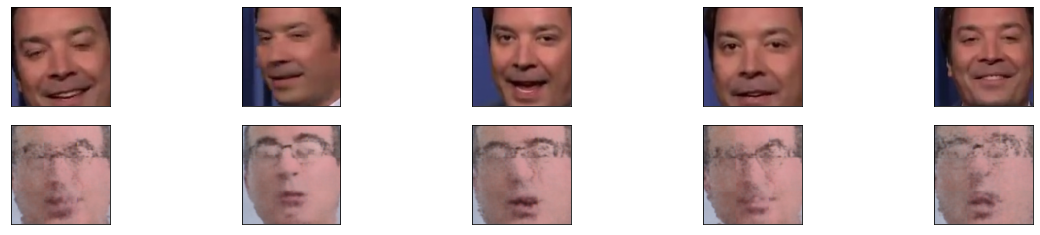

In [9]:
with torch.no_grad():
    number = 5
    plt.figure(figsize=(20, 4))
    randomlist = random.sample(range(0, len(input_frames)), 5)
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        img = cv2.cvtColor((input_frames[randomlist[index]].cpu().detach().numpy().reshape(128, 128, 3)*(255)).astype(np.uint8), cv2.COLOR_BGR2RGB)
        plt.imshow(img)

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        img = cv2.cvtColor(((generated[randomlist[index]].numpy().reshape(128, 128,3))*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        plt.imshow(img)

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Stitch together the generated images into a video
You will find the generated video under Files to the left in a video file called "oliver.avi". You can download it to watch it. It is also avaliable under "Ouput Videos" in our repo (https://github.com/arjungandhi521/deepfake-generation).

In [11]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video=cv2.VideoWriter('oliver.avi', fourcc, 15,(128,128))
print(input_frames.shape)
for j in range(input_frames.shape[0]):
    video.write(((generated[j].cpu().detach().view(128,128,3).numpy()*255)).astype(np.uint8))

cv2.destroyAllWindows()
video.release()

torch.Size([1734, 3, 128, 128])
